### Acquire cat & dog image data from Kaggle

In [2]:
!mkdir /Users/crisliu/transfer-learning-Keras/data
!mkdir /Users/crisliu/transfer-learning-Keras/data/train
!mkdir /Users/crisliu/transfer-learning-Keras/data/test

In [6]:
!unzip /Users/crisliu/Downloads/test1.zip -d /Users/crisliu/transfer-learning-Keras/data/test

Archive:  /Users/crisliu/Downloads/test1.zip
   creating: /Users/crisliu/transfer-learning-Keras/data/test/test1/
  inflating: /Users/crisliu/transfer-learning-Keras/data/test/test1/1.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/test/test1/10.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/test/test1/100.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/test/test1/1000.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/test/test1/10000.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/test/test1/10001.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/test/test1/10002.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/test/test1/10003.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/test/test1/10004.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/test/test1/10005.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/test/test1/10006.jpg  
  inflating: /Us

In [17]:
!unzip /Users/crisliu/Downloads/train.zip -d /Users/crisliu/transfer-learning-Keras/data/

Archive:  /Users/crisliu/Downloads/train.zip
  inflating: /Users/crisliu/transfer-learning-Keras/data/train/cat.0.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/train/cat.1.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/train/cat.10.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/train/cat.100.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/train/cat.1000.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/train/cat.10000.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/train/cat.10001.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/train/cat.10002.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/train/cat.10003.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/train/cat.10004.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/train/cat.10005.jpg  
  inflating: /Users/crisliu/transfer-learning-Keras/data/train/cat.10006.jpg  
  inflating: /Users/c

### Choose 1000 images of cats and dogs for training, respectively, and 400 for validation.

In [20]:
!mkdir /Users/crisliu/transfer-learning-Keras/data/train/dogs
!mkdir /Users/crisliu/transfer-learning-Keras/data/train/cats
!mkdir /Users/crisliu/transfer-learning-Keras/data/validation
!mkdir /Users/crisliu/transfer-learning-Keras/data/validation/dogs
!mkdir /Users/crisliu/transfer-learning-Keras/data/validation/cats

In [36]:
for i in range(1000):
    string = "/Users/crisliu/transfer-learning-Keras/data/train/cat.%s.jpg"%str(i)
    !cp  $string /Users/crisliu/transfer-learning-Keras/data/train/cats
    string = "/Users/crisliu/transfer-learning-Keras/data/train/dog.%s.jpg"%str(i)
    !cp  $string /Users/crisliu/transfer-learning-Keras/data/train/dogs

In [38]:
for i in range(1000,1400):
    string = "/Users/crisliu/transfer-learning-Keras/data/train/cat.%s.jpg"%str(i)
    !cp  $string /Users/crisliu/transfer-learning-Keras/data/validation/cats
    string = "/Users/crisliu/transfer-learning-Keras/data/train/dog.%s.jpg"%str(i)
    !cp  $string /Users/crisliu/transfer-learning-Keras/data/validation/dogs

In [79]:
nb_train_samples = 2000
nb_validation_samples = 800

#### We will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In [48]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/Users/crisliu/transfer-learning-Keras/data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
!mkdir /Users/crisliu/transfer-learning-Keras/data/preview
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='/Users/crisliu/transfer-learning-Keras/data/preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

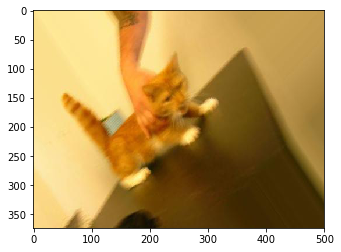

In [56]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/Users/crisliu/transfer-learning-Keras/data/preview/cat_0_270.jpeg', 'r')
imshow(np.asarray(pil_im))


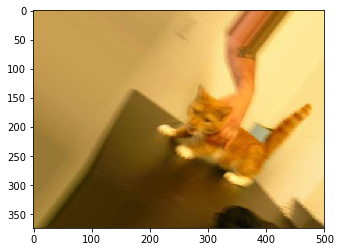

In [58]:
pil_im = Image.open('/Users/crisliu/transfer-learning-Keras/data/preview/cat_0_7686.jpeg', 'r')
imshow(np.asarray(pil_im))

Data augmentation is one way to fight overfitting, but it isn't enough since our augmented samples are still highly correlated. Your main focus for fighting overfitting should be the entropic capacity of your model --how much information your model is allowed to store.

## Model 1

The first (benchmark) model, is a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU).

In [62]:

from keras import backend as K

# dimensions of our images.
img_width, img_height = 150, 150

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [67]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

In [68]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [69]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/Users/crisliu/transfer-learning-Keras/data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '/Users/crisliu/transfer-learning-Keras/data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [70]:
model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)
model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
125/125 [==============================] - 56s - loss: 0.7342 - acc: 0.5095 - val_loss: 0.6884 - val_acc: 0.6300

## Model 2

A more refined approach would be to leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

we will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then we will train a small fully-connected model on top of the stored features.

In [76]:
from keras import applications
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        '/Users/crisliu/transfer-learning-Keras/data/train',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'w'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        '/Users/crisliu/transfer-learning-Keras/data/validation',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'w'),
            bottleneck_features_validation)
save_bottlebeck_features()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [109]:
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy'))
    train_labels = np.array(
        [0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))

    validation_data = np.load(open('bottleneck_features_validation.npy'))
    validation_labels = np.array(
        [0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=50,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights('bottleneck_fc_model.h5')
train_top_model()

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 3s - loss: 0.7114 - acc: 0.7660 - val_loss: 0.3588 - val_acc: 0.8438

## Model 3

instantiate the convolutional base of VGG16 and load its weights

add our previously defined fully-connected model on top, and load its weights

freeze the layers of the VGG16 model up to the last convolutional block

In [119]:

# build the VGG16 network
model = applications.VGG16(weights='imagenet', include_top=False,input_shape=input_shape)
print('Model loaded.')
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights('bottleneck_fc_model.h5')

# add the model on top of the convolutional base
# Fix the bug
from keras.engine.training import Model
model = Model(inputs=model.input, outputs=top_model(model.output))

Model loaded.


In [ ]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/Users/crisliu/transfer-learning-Keras/data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '/Users/crisliu/transfer-learning-Keras/data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

# fine-tune the model
model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50
 17/125 [===>..........................] - ETA: 373s - loss: 0.6316 - acc: 0.9412